CSC with a Spatial Mask
=======================

This example demonstrates the use of [cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) for convolutional sparse coding with a spatial mask [[29]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2016-boundary). The example problem is inpainting of randomly distributed corruption of a colour image [[30]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2016-convolutional).

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco.admm import tvl2
from sporco.admm import cbpdn
from sporco import util
from sporco import metric
from sporco import plot
plot.config_notebook_plotting()

Load a reference image.

In [2]:
img = util.ExampleImages().image('monarch.png', zoom=0.5, scaled=True,
                                 idxexp=np.s_[:, 160:672])

Create random mask and apply to reference image to obtain test image. (The call to ``numpy.random.seed`` ensures that the pseudo-random noise is reproducible.)

In [3]:
t = 0.5
np.random.seed(12345)
msk = np.random.randn(*(img.shape))
msk[np.abs(msk) > t] = 1;
msk[np.abs(msk) < t] = 0;
imgw = msk * img

Define pad and crop functions.

In [4]:
pn = 8
spad = lambda x:  np.pad(x, ((pn, pn), (pn, pn), (0, 0)), mode='symmetric')
zpad = lambda x:  np.pad(x, ((pn, pn), (pn, pn), (0, 0)), mode='constant')
crop = lambda x: x[pn:-pn, pn:-pn]

Construct padded mask and test image.

In [5]:
mskp = zpad(msk)
imgwp = spad(imgw)

:math:`\ell_2`-TV denoising with a spatial mask as a non-linear lowpass
filter.

In [6]:
lmbda = 0.05
opt = tvl2.TVL2Denoise.Options({'Verbose': False, 'MaxMainIter': 200,
                    'DFidWeight': mskp, 'gEvalY': False,
                    'AutoRho': {'Enabled': True}})
b = tvl2.TVL2Denoise(imgwp, lmbda, opt, caxis=2)
sl = b.solve()
sh = imgwp - sl

Load dictionary.

In [7]:
D = util.convdicts()['RGB:8x8x3x64']

Set up [admm.cbpdn.ConvBPDN](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDN) options.

In [8]:
lmbda = 2e-2
opt = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': 250,
                    'HighMemSolve': True, 'RelStopTol': 1e-3,
                    'AuxVarObj': False, 'RelaxParam': 1.8,
                    'rho': 5e1*lmbda + 1e-1, 'AutoRho': {'Enabled': False,
                    'StdResiduals': True}})

Construct [admm.cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) wrapper for :class`.admm.cbpdn.ConvBPDN` and solve via wrapper. This example could also have made use of :class`.admm.cbpdn.ConvBPDNMaskDcpl`, which has very similar performance in this application, but [admm.cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) has the advantage of greater flexibility in that the wrapper can be applied to a variety of CSC solver objects.

In [9]:
ams = cbpdn.AddMaskSim(cbpdn.ConvBPDN, D, sh, mskp, lmbda, opt=opt)
X = ams.solve()

Itn   Fnc       DFid      Regℓ1     r         s         
------------------------------------------------------


   0  1.76e+03  1.21e+03  2.72e+04  3.95e+01  8.21e+01


   1  9.56e+02  4.58e+02  2.49e+04  3.02e+01  4.40e+01


   2  3.89e+02  5.94e+01  1.65e+04  1.34e+01  1.61e+01


   3  2.89e+02  3.60e+01  1.26e+04  9.87e+00  1.10e+01


   4  2.17e+02  1.94e+01  9.87e+03  7.38e+00  7.58e+00


   5  1.76e+02  1.26e+01  8.18e+03  5.89e+00  5.91e+00


   6  1.39e+02  8.59e+00  6.53e+03  4.76e+00  4.78e+00


   7  1.16e+02  6.47e+00  5.49e+03  3.90e+00  3.99e+00


   8  9.60e+01  5.23e+00  4.54e+03  3.23e+00  3.41e+00


   9  8.24e+01  4.48e+00  3.90e+03  2.70e+00  2.97e+00


  10  7.05e+01  4.00e+00  3.33e+03  2.28e+00  2.63e+00


  11  6.21e+01  3.68e+00  2.92e+03  1.94e+00  2.36e+00


  12  5.48e+01  3.47e+00  2.57e+03  1.68e+00  2.14e+00


  13  4.94e+01  3.33e+00  2.31e+03  1.47e+00  1.95e+00


  14  4.47e+01  3.24e+00  2.07e+03  1.30e+00  1.79e+00


  15  4.11e+01  3.18e+00  1.90e+03  1.17e+00  1.66e+00


  16  3.79e+01  3.14e+00  1.74e+03  1.06e+00  1.55e+00


  17  3.53e+01  3.12e+00  1.61e+03  9.67e-01  1.45e+00


  18  3.29e+01  3.11e+00  1.49e+03  8.92e-01  1.38e+00


  19  3.11e+01  3.10e+00  1.40e+03  8.29e-01  1.30e+00


  20  2.94e+01  3.09e+00  1.32e+03  7.76e-01  1.24e+00


  21  2.81e+01  3.09e+00  1.25e+03  7.31e-01  1.17e+00


  22  2.69e+01  3.09e+00  1.19e+03  6.91e-01  1.11e+00


  23  2.60e+01  3.08e+00  1.14e+03  6.57e-01  1.06e+00


  24  2.51e+01  3.08e+00  1.10e+03  6.25e-01  1.00e+00


  25  2.43e+01  3.08e+00  1.06e+03  5.96e-01  9.57e-01


  26  2.36e+01  3.08e+00  1.03e+03  5.70e-01  9.11e-01


  27  2.30e+01  3.08e+00  9.96e+02  5.46e-01  8.68e-01


  28  2.25e+01  3.08e+00  9.70e+02  5.23e-01  8.27e-01


  29  2.20e+01  3.09e+00  9.46e+02  5.03e-01  7.90e-01


  30  2.16e+01  3.09e+00  9.23e+02  4.84e-01  7.58e-01


  31  2.11e+01  3.10e+00  9.01e+02  4.66e-01  7.28e-01


  32  2.07e+01  3.10e+00  8.79e+02  4.50e-01  7.01e-01


  33  2.03e+01  3.11e+00  8.57e+02  4.34e-01  6.77e-01


  34  1.99e+01  3.11e+00  8.38e+02  4.20e-01  6.54e-01


  35  1.95e+01  3.12e+00  8.20e+02  4.06e-01  6.33e-01


  36  1.92e+01  3.12e+00  8.03e+02  3.94e-01  6.13e-01


  37  1.89e+01  3.13e+00  7.88e+02  3.82e-01  5.94e-01


  38  1.86e+01  3.14e+00  7.74e+02  3.72e-01  5.76e-01


  39  1.84e+01  3.14e+00  7.62e+02  3.62e-01  5.59e-01


  40  1.82e+01  3.14e+00  7.50e+02  3.52e-01  5.40e-01


  41  1.80e+01  3.15e+00  7.40e+02  3.43e-01  5.23e-01


  42  1.78e+01  3.15e+00  7.30e+02  3.35e-01  5.07e-01


  43  1.76e+01  3.16e+00  7.21e+02  3.27e-01  4.93e-01


  44  1.74e+01  3.16e+00  7.11e+02  3.19e-01  4.80e-01


  45  1.72e+01  3.17e+00  7.01e+02  3.11e-01  4.68e-01


  46  1.70e+01  3.17e+00  6.92e+02  3.04e-01  4.58e-01


  47  1.68e+01  3.17e+00  6.83e+02  2.98e-01  4.49e-01


  48  1.67e+01  3.18e+00  6.74e+02  2.91e-01  4.40e-01


  49  1.65e+01  3.18e+00  6.66e+02  2.85e-01  4.32e-01


  50  1.64e+01  3.18e+00  6.58e+02  2.80e-01  4.24e-01


  51  1.62e+01  3.19e+00  6.51e+02  2.74e-01  4.17e-01


  52  1.61e+01  3.19e+00  6.44e+02  2.69e-01  4.10e-01


  53  1.59e+01  3.19e+00  6.37e+02  2.64e-01  4.03e-01


  54  1.58e+01  3.19e+00  6.31e+02  2.59e-01  3.96e-01


  55  1.57e+01  3.19e+00  6.25e+02  2.55e-01  3.90e-01


  56  1.56e+01  3.20e+00  6.18e+02  2.51e-01  3.84e-01


  57  1.55e+01  3.20e+00  6.13e+02  2.47e-01  3.78e-01


  58  1.53e+01  3.20e+00  6.07e+02  2.43e-01  3.72e-01


  59  1.53e+01  3.20e+00  6.02e+02  2.39e-01  3.66e-01


  60  1.52e+01  3.20e+00  5.98e+02  2.35e-01  3.61e-01


  61  1.51e+01  3.21e+00  5.94e+02  2.32e-01  3.55e-01


  62  1.50e+01  3.21e+00  5.89e+02  2.28e-01  3.50e-01


  63  1.49e+01  3.21e+00  5.85e+02  2.25e-01  3.45e-01


  64  1.48e+01  3.21e+00  5.81e+02  2.22e-01  3.40e-01


  65  1.47e+01  3.21e+00  5.77e+02  2.19e-01  3.36e-01


  66  1.47e+01  3.21e+00  5.73e+02  2.16e-01  3.32e-01


  67  1.46e+01  3.21e+00  5.69e+02  2.13e-01  3.28e-01


  68  1.45e+01  3.21e+00  5.65e+02  2.10e-01  3.24e-01


  69  1.44e+01  3.21e+00  5.61e+02  2.07e-01  3.21e-01


  70  1.44e+01  3.22e+00  5.57e+02  2.04e-01  3.17e-01


  71  1.43e+01  3.22e+00  5.53e+02  2.02e-01  3.14e-01


  72  1.42e+01  3.22e+00  5.50e+02  1.99e-01  3.11e-01


  73  1.42e+01  3.22e+00  5.47e+02  1.97e-01  3.08e-01


  74  1.41e+01  3.22e+00  5.43e+02  1.94e-01  3.05e-01


  75  1.40e+01  3.22e+00  5.40e+02  1.92e-01  3.02e-01


  76  1.40e+01  3.22e+00  5.38e+02  1.90e-01  2.99e-01


  77  1.39e+01  3.22e+00  5.35e+02  1.88e-01  2.95e-01


  78  1.39e+01  3.23e+00  5.33e+02  1.86e-01  2.92e-01


  79  1.38e+01  3.23e+00  5.30e+02  1.84e-01  2.88e-01


  80  1.38e+01  3.23e+00  5.28e+02  1.82e-01  2.84e-01


  81  1.37e+01  3.23e+00  5.26e+02  1.81e-01  2.81e-01


  82  1.37e+01  3.23e+00  5.24e+02  1.79e-01  2.77e-01


  83  1.37e+01  3.23e+00  5.22e+02  1.77e-01  2.73e-01


  84  1.36e+01  3.23e+00  5.20e+02  1.76e-01  2.70e-01


  85  1.36e+01  3.23e+00  5.18e+02  1.74e-01  2.66e-01


  86  1.36e+01  3.23e+00  5.16e+02  1.72e-01  2.63e-01


  87  1.35e+01  3.23e+00  5.14e+02  1.71e-01  2.60e-01


  88  1.35e+01  3.23e+00  5.13e+02  1.69e-01  2.57e-01


  89  1.35e+01  3.24e+00  5.11e+02  1.68e-01  2.55e-01


  90  1.34e+01  3.24e+00  5.09e+02  1.66e-01  2.52e-01


  91  1.34e+01  3.24e+00  5.07e+02  1.65e-01  2.50e-01


  92  1.33e+01  3.24e+00  5.05e+02  1.63e-01  2.47e-01


  93  1.33e+01  3.24e+00  5.04e+02  1.62e-01  2.45e-01


  94  1.33e+01  3.24e+00  5.02e+02  1.60e-01  2.43e-01


  95  1.32e+01  3.24e+00  5.00e+02  1.59e-01  2.41e-01


  96  1.32e+01  3.24e+00  4.99e+02  1.58e-01  2.39e-01


  97  1.32e+01  3.24e+00  4.97e+02  1.56e-01  2.37e-01


  98  1.31e+01  3.24e+00  4.95e+02  1.55e-01  2.35e-01


  99  1.31e+01  3.24e+00  4.94e+02  1.54e-01  2.33e-01


 100  1.31e+01  3.24e+00  4.93e+02  1.52e-01  2.31e-01


 101  1.31e+01  3.24e+00  4.91e+02  1.51e-01  2.29e-01


 102  1.30e+01  3.24e+00  4.90e+02  1.50e-01  2.27e-01


 103  1.30e+01  3.24e+00  4.89e+02  1.49e-01  2.25e-01


 104  1.30e+01  3.24e+00  4.87e+02  1.48e-01  2.24e-01


 105  1.30e+01  3.24e+00  4.86e+02  1.47e-01  2.22e-01


 106  1.29e+01  3.25e+00  4.85e+02  1.45e-01  2.20e-01


 107  1.29e+01  3.25e+00  4.83e+02  1.44e-01  2.19e-01


 108  1.29e+01  3.25e+00  4.82e+02  1.43e-01  2.18e-01


 109  1.29e+01  3.25e+00  4.81e+02  1.42e-01  2.16e-01


 110  1.28e+01  3.25e+00  4.80e+02  1.41e-01  2.15e-01


 111  1.28e+01  3.25e+00  4.78e+02  1.40e-01  2.15e-01


 112  1.28e+01  3.25e+00  4.77e+02  1.38e-01  2.14e-01


 113  1.28e+01  3.25e+00  4.76e+02  1.37e-01  2.13e-01


 114  1.27e+01  3.25e+00  4.74e+02  1.36e-01  2.12e-01


 115  1.27e+01  3.25e+00  4.73e+02  1.35e-01  2.11e-01


 116  1.27e+01  3.25e+00  4.72e+02  1.34e-01  2.11e-01


 117  1.27e+01  3.25e+00  4.71e+02  1.33e-01  2.10e-01


 118  1.26e+01  3.25e+00  4.70e+02  1.32e-01  2.09e-01


 119  1.26e+01  3.25e+00  4.69e+02  1.31e-01  2.07e-01


 120  1.26e+01  3.25e+00  4.68e+02  1.30e-01  2.06e-01


 121  1.26e+01  3.25e+00  4.67e+02  1.29e-01  2.05e-01


 122  1.26e+01  3.25e+00  4.66e+02  1.28e-01  2.03e-01


 123  1.26e+01  3.25e+00  4.66e+02  1.28e-01  2.02e-01


 124  1.25e+01  3.25e+00  4.65e+02  1.27e-01  2.00e-01


 125  1.25e+01  3.25e+00  4.64e+02  1.26e-01  1.98e-01


 126  1.25e+01  3.25e+00  4.63e+02  1.25e-01  1.96e-01


 127  1.25e+01  3.25e+00  4.63e+02  1.25e-01  1.95e-01


 128  1.25e+01  3.25e+00  4.62e+02  1.24e-01  1.93e-01


 129  1.25e+01  3.25e+00  4.61e+02  1.23e-01  1.91e-01


 130  1.25e+01  3.25e+00  4.61e+02  1.22e-01  1.89e-01


 131  1.25e+01  3.25e+00  4.60e+02  1.22e-01  1.87e-01


 132  1.24e+01  3.25e+00  4.60e+02  1.21e-01  1.85e-01


 133  1.24e+01  3.25e+00  4.59e+02  1.20e-01  1.84e-01


 134  1.24e+01  3.25e+00  4.59e+02  1.20e-01  1.82e-01


 135  1.24e+01  3.25e+00  4.58e+02  1.19e-01  1.80e-01


 136  1.24e+01  3.25e+00  4.58e+02  1.18e-01  1.78e-01


 137  1.24e+01  3.25e+00  4.57e+02  1.18e-01  1.77e-01


 138  1.24e+01  3.25e+00  4.56e+02  1.17e-01  1.75e-01


 139  1.24e+01  3.25e+00  4.56e+02  1.16e-01  1.74e-01


 140  1.24e+01  3.25e+00  4.55e+02  1.15e-01  1.73e-01


 141  1.23e+01  3.25e+00  4.55e+02  1.15e-01  1.72e-01


 142  1.23e+01  3.25e+00  4.54e+02  1.14e-01  1.71e-01


 143  1.23e+01  3.25e+00  4.53e+02  1.13e-01  1.70e-01


 144  1.23e+01  3.25e+00  4.53e+02  1.12e-01  1.70e-01


 145  1.23e+01  3.25e+00  4.52e+02  1.12e-01  1.69e-01


 146  1.23e+01  3.25e+00  4.51e+02  1.11e-01  1.69e-01


 147  1.23e+01  3.25e+00  4.50e+02  1.10e-01  1.68e-01


 148  1.22e+01  3.26e+00  4.50e+02  1.09e-01  1.68e-01


 149  1.22e+01  3.26e+00  4.49e+02  1.09e-01  1.68e-01


 150  1.22e+01  3.26e+00  4.48e+02  1.08e-01  1.67e-01


 151  1.22e+01  3.26e+00  4.48e+02  1.07e-01  1.67e-01


 152  1.22e+01  3.26e+00  4.47e+02  1.07e-01  1.66e-01


 153  1.22e+01  3.26e+00  4.46e+02  1.06e-01  1.66e-01


 154  1.22e+01  3.26e+00  4.46e+02  1.05e-01  1.65e-01


 155  1.22e+01  3.26e+00  4.45e+02  1.05e-01  1.65e-01


 156  1.22e+01  3.26e+00  4.45e+02  1.04e-01  1.64e-01


 157  1.21e+01  3.26e+00  4.44e+02  1.03e-01  1.63e-01


 158  1.21e+01  3.26e+00  4.44e+02  1.03e-01  1.62e-01


 159  1.21e+01  3.26e+00  4.43e+02  1.02e-01  1.61e-01


 160  1.21e+01  3.26e+00  4.43e+02  1.02e-01  1.60e-01


 161  1.21e+01  3.26e+00  4.42e+02  1.01e-01  1.59e-01


 162  1.21e+01  3.26e+00  4.42e+02  1.01e-01  1.57e-01


 163  1.21e+01  3.26e+00  4.42e+02  1.00e-01  1.56e-01


 164  1.21e+01  3.26e+00  4.41e+02  9.98e-02  1.55e-01


 165  1.21e+01  3.26e+00  4.41e+02  9.93e-02  1.53e-01


 166  1.21e+01  3.26e+00  4.41e+02  9.88e-02  1.52e-01


 167  1.21e+01  3.26e+00  4.40e+02  9.83e-02  1.51e-01


 168  1.21e+01  3.26e+00  4.40e+02  9.78e-02  1.50e-01


 169  1.21e+01  3.26e+00  4.40e+02  9.73e-02  1.49e-01


 170  1.20e+01  3.26e+00  4.39e+02  9.68e-02  1.48e-01


 171  1.20e+01  3.26e+00  4.39e+02  9.62e-02  1.47e-01


 172  1.20e+01  3.26e+00  4.38e+02  9.57e-02  1.47e-01


 173  1.20e+01  3.26e+00  4.38e+02  9.51e-02  1.46e-01


 174  1.20e+01  3.26e+00  4.37e+02  9.46e-02  1.46e-01


 175  1.20e+01  3.26e+00  4.37e+02  9.40e-02  1.45e-01


 176  1.20e+01  3.26e+00  4.36e+02  9.35e-02  1.45e-01


 177  1.20e+01  3.26e+00  4.36e+02  9.30e-02  1.44e-01


 178  1.20e+01  3.26e+00  4.36e+02  9.25e-02  1.43e-01


 179  1.20e+01  3.26e+00  4.35e+02  9.20e-02  1.43e-01


 180  1.20e+01  3.26e+00  4.35e+02  9.15e-02  1.42e-01


 181  1.19e+01  3.26e+00  4.35e+02  9.10e-02  1.42e-01


 182  1.19e+01  3.26e+00  4.34e+02  9.06e-02  1.41e-01


 183  1.19e+01  3.26e+00  4.34e+02  9.01e-02  1.40e-01


 184  1.19e+01  3.26e+00  4.34e+02  8.97e-02  1.39e-01


 185  1.19e+01  3.26e+00  4.33e+02  8.93e-02  1.38e-01


 186  1.19e+01  3.26e+00  4.33e+02  8.89e-02  1.37e-01


 187  1.19e+01  3.26e+00  4.33e+02  8.85e-02  1.36e-01


 188  1.19e+01  3.26e+00  4.33e+02  8.81e-02  1.35e-01


 189  1.19e+01  3.26e+00  4.32e+02  8.77e-02  1.34e-01


 190  1.19e+01  3.26e+00  4.32e+02  8.73e-02  1.33e-01


 191  1.19e+01  3.26e+00  4.32e+02  8.69e-02  1.33e-01


 192  1.19e+01  3.26e+00  4.32e+02  8.65e-02  1.32e-01


 193  1.19e+01  3.26e+00  4.31e+02  8.61e-02  1.31e-01


 194  1.19e+01  3.26e+00  4.31e+02  8.57e-02  1.30e-01


 195  1.19e+01  3.26e+00  4.31e+02  8.52e-02  1.30e-01


 196  1.19e+01  3.26e+00  4.30e+02  8.48e-02  1.29e-01


 197  1.19e+01  3.26e+00  4.30e+02  8.43e-02  1.28e-01


 198  1.19e+01  3.26e+00  4.30e+02  8.39e-02  1.28e-01


 199  1.18e+01  3.26e+00  4.29e+02  8.34e-02  1.27e-01


 200  1.18e+01  3.26e+00  4.29e+02  8.30e-02  1.27e-01


 201  1.18e+01  3.26e+00  4.29e+02  8.25e-02  1.27e-01


 202  1.18e+01  3.26e+00  4.28e+02  8.21e-02  1.26e-01


 203  1.18e+01  3.26e+00  4.28e+02  8.17e-02  1.26e-01


 204  1.18e+01  3.26e+00  4.28e+02  8.12e-02  1.26e-01


 205  1.18e+01  3.26e+00  4.27e+02  8.08e-02  1.25e-01


 206  1.18e+01  3.26e+00  4.27e+02  8.03e-02  1.25e-01


 207  1.18e+01  3.26e+00  4.27e+02  7.99e-02  1.24e-01


 208  1.18e+01  3.26e+00  4.26e+02  7.95e-02  1.24e-01


 209  1.18e+01  3.26e+00  4.26e+02  7.91e-02  1.24e-01


 210  1.18e+01  3.26e+00  4.26e+02  7.87e-02  1.23e-01


 211  1.18e+01  3.26e+00  4.26e+02  7.83e-02  1.23e-01


 212  1.18e+01  3.26e+00  4.25e+02  7.80e-02  1.22e-01


 213  1.18e+01  3.26e+00  4.25e+02  7.76e-02  1.22e-01


 214  1.18e+01  3.26e+00  4.25e+02  7.72e-02  1.21e-01


 215  1.18e+01  3.26e+00  4.25e+02  7.69e-02  1.20e-01


 216  1.17e+01  3.26e+00  4.24e+02  7.65e-02  1.20e-01


 217  1.17e+01  3.26e+00  4.24e+02  7.62e-02  1.19e-01


 218  1.17e+01  3.26e+00  4.24e+02  7.59e-02  1.19e-01


 219  1.17e+01  3.26e+00  4.24e+02  7.55e-02  1.18e-01


 220  1.17e+01  3.26e+00  4.23e+02  7.52e-02  1.17e-01


 221  1.17e+01  3.26e+00  4.23e+02  7.49e-02  1.16e-01


 222  1.17e+01  3.26e+00  4.23e+02  7.46e-02  1.16e-01


 223  1.17e+01  3.26e+00  4.23e+02  7.43e-02  1.15e-01


 224  1.17e+01  3.26e+00  4.23e+02  7.40e-02  1.14e-01


 225  1.17e+01  3.26e+00  4.23e+02  7.36e-02  1.13e-01


 226  1.17e+01  3.26e+00  4.23e+02  7.33e-02  1.13e-01


 227  1.17e+01  3.26e+00  4.22e+02  7.30e-02  1.12e-01


 228  1.17e+01  3.26e+00  4.22e+02  7.27e-02  1.11e-01


 229  1.17e+01  3.26e+00  4.22e+02  7.24e-02  1.11e-01


 230  1.17e+01  3.26e+00  4.22e+02  7.21e-02  1.10e-01


 231  1.17e+01  3.26e+00  4.22e+02  7.18e-02  1.10e-01


 232  1.17e+01  3.26e+00  4.21e+02  7.14e-02  1.09e-01


 233  1.17e+01  3.26e+00  4.21e+02  7.11e-02  1.09e-01


 234  1.17e+01  3.26e+00  4.21e+02  7.08e-02  1.08e-01


 235  1.17e+01  3.26e+00  4.21e+02  7.05e-02  1.08e-01


 236  1.17e+01  3.26e+00  4.21e+02  7.01e-02  1.07e-01


 237  1.17e+01  3.26e+00  4.20e+02  6.98e-02  1.07e-01


 238  1.17e+01  3.26e+00  4.20e+02  6.95e-02  1.06e-01


 239  1.17e+01  3.26e+00  4.20e+02  6.92e-02  1.06e-01


 240  1.17e+01  3.26e+00  4.20e+02  6.88e-02  1.05e-01


 241  1.17e+01  3.26e+00  4.19e+02  6.85e-02  1.05e-01


 242  1.16e+01  3.26e+00  4.19e+02  6.82e-02  1.05e-01


 243  1.16e+01  3.26e+00  4.19e+02  6.79e-02  1.04e-01


 244  1.16e+01  3.26e+00  4.19e+02  6.75e-02  1.04e-01


 245  1.16e+01  3.26e+00  4.19e+02  6.72e-02  1.04e-01


 246  1.16e+01  3.26e+00  4.18e+02  6.69e-02  1.03e-01


 247  1.16e+01  3.26e+00  4.18e+02  6.66e-02  1.03e-01


 248  1.16e+01  3.26e+00  4.18e+02  6.63e-02  1.03e-01


 249  1.16e+01  3.26e+00  4.18e+02  6.59e-02  1.02e-01
------------------------------------------------------


Reconstruct from representation.

In [10]:
imgr = crop(sl + ams.reconstruct().squeeze())

Display solve time and reconstruction performance.

In [11]:
print("AddMaskSim wrapped ConvBPDN solve time: %.2fs" %
      ams.timer.elapsed('solve'))
print("Corrupted image PSNR: %5.2f dB" % metric.psnr(img, imgw))
print("Recovered image PSNR: %5.2f dB" % metric.psnr(img, imgr))

AddMaskSim wrapped ConvBPDN solve time: 339.56s
Corrupted image PSNR: 11.68 dB
Recovered image PSNR: 31.58 dB


Display reference, test, and reconstructed image

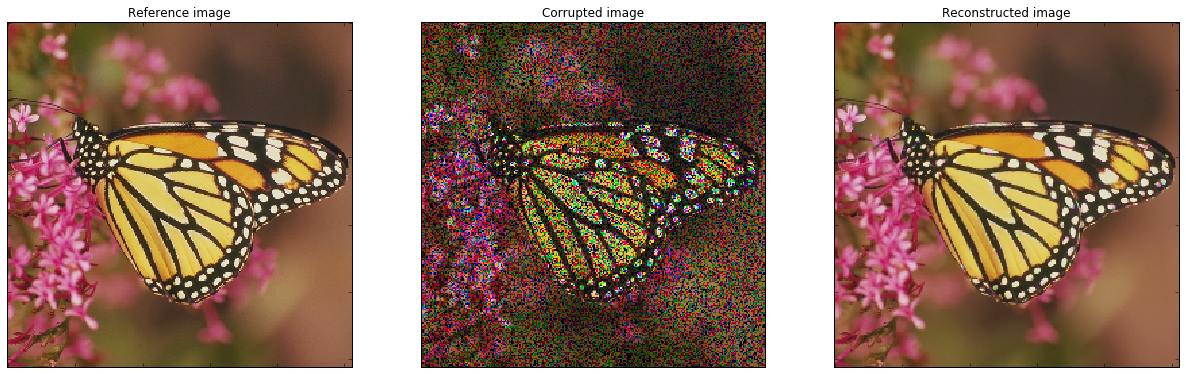

In [12]:
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.imview(img, fgrf=fig, title='Reference image')
plot.subplot(1, 3, 2)
plot.imview(imgw, fgrf=fig, title='Corrupted image')
plot.subplot(1, 3, 3)
plot.imview(imgr, fgrf=fig, title='Reconstructed image')
fig.show()

Display lowpass component and sparse representation

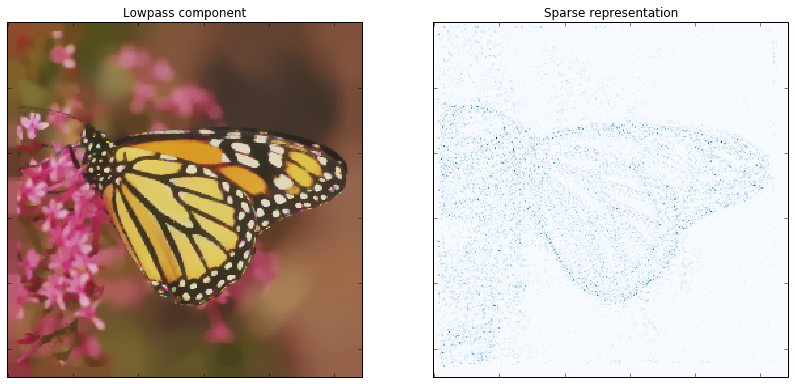

In [13]:
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(sl, fgrf=fig, cmap=plot.cm.Blues, title='Lowpass component')
plot.subplot(1, 2, 2)
plot.imview(np.squeeze(np.sum(abs(X), axis=ams.cri.axisM)), fgrf=fig,
            cmap=plot.cm.Blues, title='Sparse representation')
fig.show()

Plot functional value, residuals, and rho

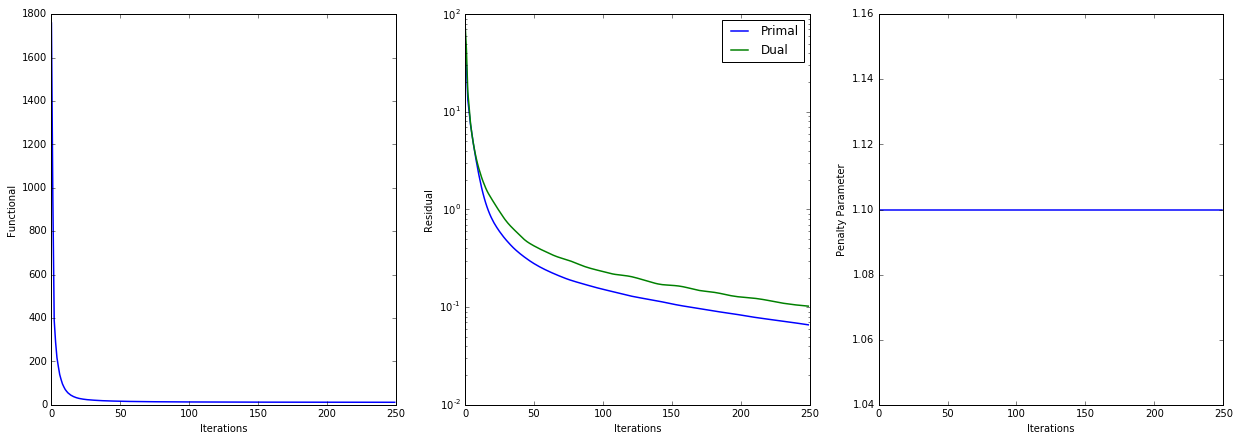

In [14]:
its = ams.getitstat()
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.plot(its.ObjFun, fgrf=fig, xlbl='Iterations', ylbl='Functional')
plot.subplot(1, 3, 2)
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T, fgrf=fig,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual'])
plot.subplot(1, 3, 3)
plot.plot(its.Rho, fgrf=fig, xlbl='Iterations', ylbl='Penalty Parameter')
fig.show()